# Import Cleaned Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

data = pd.read_csv('./data/cleaned.csv', encoding='utf-8')

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()

def tokenize(tweet):
    try:
        tokens = tokenizer.tokenize(tweet)
        return tokens
    except:
        return 'NC'

def scaling(target):
    if(target == 4):
        return 1
    else:
        return 0

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Post Process

In [2]:
# post process
data['target'] = data['target'].progress_map(scaling)
data['clean_text'] = data['clean_text'].progress_map(tokenize)
data = data[data.clean_text != 'NC']
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
print(data.head())
print(data.tail())

progress-bar: 100%|██████████| 1600000/1600000 [00:28<00:00, 55321.61it/s]


   target                                         clean_text
0       0  [http, twitpic, awww, that, bummer, shoulda, d...
1       0  [upset, that, updat, facebook, text, might, re...
2       0  [dive, mani, time, ball, manag, save, rest, bo...
3       0             [whole, bodi, feel, itchi, like, fire]
4       0                 [behav, here, becaus, over, there]
         target                                         clean_text
1586995       1       [just, woke, have, school, best, feel, ever]
1586996       1  [thewdb, veri, cool, hear, walt, interview, ht...
1586997       1                [readi, your, mojo, makeov, detail]
1586998       1  [happi, birthday, alll, time, tupac, amaru, sh...
1586999       1                           [happi, #charitytuesday]


# Split into Train and Test Data

In [3]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data['clean_text']), np.array(data['target']),
                                                    test_size=0.2)
x_test_pure = x_test

# Word2Vec

In [4]:
import gensim
from gensim.models.word2vec import Word2Vec
LabeledSentence = gensim.models.doc2vec.LabeledSentence

def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
print(x_train[0:2])
x_test = labelizeTweets(x_test, 'TEST')

print("Building word2vec matrix")
n_dim = 300
tweet_w2v = Word2Vec(size=n_dim, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)], total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.epochs)

C:\Users\josh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
0it [00:00, ?it/s]C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if __name__ == '__main__':
1269600it [00:05, 240121.95it/s]


[LabeledSentence(words=['woke', 'middl', 'night', 'need', 'back', 'sleep'], tags=['TRAIN_0']), LabeledSentence(words=['afaik', 'pinot', 'also', 'also', 'bakeri', 'outlet', 'basement'], tags=['TRAIN_1'])]


317400it [00:01, 311275.65it/s]


Building word2vec matrix


100%|██████████| 1269600/1269600 [00:00<00:00, 2382823.35it/s]


(36990326, 43742610)

In [5]:
tweet_w2v.most_similar("good")

C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.6410046815872192),
 ('rough', 0.5300723314285278),
 ('goood', 0.5216195583343506),
 ('gooood', 0.48010364174842834),
 ('decent', 0.4767211675643921),
 ('fantast', 0.46157869696617126),
 ('fabul', 0.4548240005970001),
 ('excel', 0.4544249176979065),
 ('goooood', 0.4536723494529724),
 ('tough', 0.4375481605529785)]

In [6]:
tweet_w2v.most_similar("facebook")

C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('bebo', 0.7130445241928101),
 ('friendster', 0.711182177066803),
 ('profil', 0.6838052272796631),
 ('myspac', 0.6793900728225708),
 ('linkedin', 0.6662228107452393),
 ('statu', 0.6409034729003906),
 ('yahoo', 0.6214652061462402),
 ('twitter', 0.6019246578216553),
 ('hotmail', 0.6005986928939819),
 ('homepag', 0.600570797920227)]

# TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
print("Building tf-idf matrix")
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print("Vocab size: ", len(tfidf))

Building tf-idf matrix
Vocab size:  20289


# Scale the Data

In [8]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec


from sklearn.preprocessing import scale
print("Scaling train vector")
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

print("Scaling test vector")
test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

Scaling train vector


0it [00:00, ?it/s]C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
1269600it [01:23, 15222.30it/s]


Scaling test vector


0it [00:00, ?it/s]C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
317400it [00:23, 13429.55it/s]


# Build Keras Based Model

In [9]:
# build keras based model
from keras.models import Sequential
from keras.layers import Dense

print("Making model")
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=300))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


Making model
Instructions for updating:
Colocations handled automatically by placer.


# Train Model

In [10]:
print("Training model")
history = model.fit(train_vecs_w2v, y_train, nb_epoch=8, batch_size=1024, validation_split=0.1, verbose=2)

Training model


C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Instructions for updating:
Use tf.cast instead.
Train on 1142640 samples, validate on 126960 samples
Epoch 1/8
 - 9s - loss: 0.5176 - acc: 0.7458 - val_loss: 0.5052 - val_acc: 0.7546
Epoch 2/8
 - 9s - loss: 0.5005 - acc: 0.7567 - val_loss: 0.4992 - val_acc: 0.7577
Epoch 3/8
 - 9s - loss: 0.4966 - acc: 0.7588 - val_loss: 0.4976 - val_acc: 0.7592
Epoch 4/8
 - 9s - loss: 0.4941 - acc: 0.7604 - val_loss: 0.4976 - val_acc: 0.7589
Epoch 5/8
 - 9s - loss: 0.4926 - acc: 0.7614 - val_loss: 0.4949 - val_acc: 0.7608
Epoch 6/8
 - 10s - loss: 0.4913 - acc: 0.7621 - val_loss: 0.4938 - val_acc: 0.7617
Epoch 7/8
 - 9s - loss: 0.4903 - acc: 0.7627 - val_loss: 0.4936 - val_acc: 0.7613
Epoch 8/8
 - 9s - loss: 0.4894 - acc: 0.7633 - val_loss: 0.4944 - val_acc: 0.7604


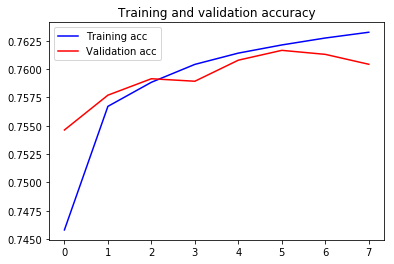

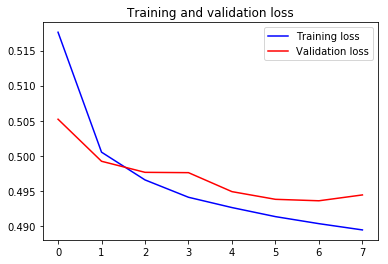

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Evaluate and Analyze Model Performance

In [12]:
print("Evaluating model")
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(score[1])

Evaluating model
0.7611594202958644


In [18]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = "NEUTRAL"
        if score < 0.45:
            label = "POSITIVE"
        elif score > 0.55:
            label = "NEGATIVE"

        return label
    else:
        return "NEGATIVE" if score < 0.5 else "POSITIVE"

In [14]:
from keras.preprocessing.sequence import pad_sequences
import time

def model_predict(tweet):
    start_at = time.time()
    # Tokenize text
    tokens = tokenizer.tokenize(tweet)
    x_test = pad_sequences(buildWordVector(tokens, 300))
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=True)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [19]:
from textblob import TextBlob

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 0
        else: 
            return 1

print("Evaluating TextBlob")
right = 0
for i, tweet in enumerate(x_test_pure):
    if(get_tweet_sentiment(" ".join(tweet)) == y_test[i]):
        right += 1
print(right/len(x_test_pure))

Evaluating TextBlob
0.41823251417769375


In [16]:
def textblob_predict(tweet):
    start_at = time.time()
    analysis = TextBlob(tweet)
    label = "NEUTRAL"
    if analysis.sentiment.polarity > 0: 
        label = "POSITIVE"
    elif analysis.sentiment.polarity == 0: 
        label = "NEUTRAL"
    else: 
        label = "NEGATIVE"
    return {"label": label, "score": float(analysis.sentiment.polarity), "elapsed_time": time.time()-start_at}

In [20]:
new_tweet = "I hate tacos"
print(model_predict(new_tweet))
print(textblob_predict(new_tweet))

C:\Users\josh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


{'label': 'POSITIVE', 'score': 0.001275300164707005, 'elapsed_time': 0.0019989013671875}
{'label': 'NEGATIVE', 'score': -0.8, 'elapsed_time': 0.0}
